In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from gs_utils import sliding_mean, sliding_stderr, max_thus_far, min_thus_far

In [60]:
root = "/Users/ivanbravi/Desktop/GAME SEARCH/_results/20-31/"
out_folder = root+"analysis_jupyter/"

os.makedirs(out_folder, exist_ok = True)

from_id = 26
to_id = 31

window_size_singles=50
window_size_true_fitness=6

In [3]:
#LOAD DATA IN df

C_e_id = "experiment"
C_true_fitness = "true_fitness"
C_true_fitness_min_thus_far = "fitness min thus far"
C_true_fitness_max_thus_far = "fitness max thus far"
C_true_fitness_moving_avg = "fitness moving average"
C_true_fitness_moving_stderr = "fitness moving stderr"
C_singles = "singles"
C_singles_min_thus_far = "single min thus far"
C_singles_max_thus_far = "single max thus far"
C_singles_moving_avg = "singles moving average"
C_singles_moving_stderr = "singles moving stderr"


df = pd.DataFrame(columns=[C_e_id,
                           C_true_fitness, C_true_fitness_min_thus_far, C_true_fitness_max_thus_far,
                           C_true_fitness_moving_avg, C_true_fitness_moving_stderr,
                           C_singles, C_singles_min_thus_far, C_singles_max_thus_far,
                           C_singles_moving_avg, C_singles_moving_stderr])

for e_id in range(from_id,to_id+1):
    in_folder = root+"log_"+str(e_id)+"/"
    
    true_fitness_file = in_folder + "FitnessTrend.json"
    with open(true_fitness_file, 'r') as f:
        true_fitness_json = json.load(f)
        true_fitness_values = [e["v2"] for e in true_fitness_json]
    
    singles_file = in_folder+"SingleEvaluations.json"
    with open(singles_file, 'r') as f:
        singles_values = json.load(f)
        
    curr_data = {
        C_e_id:                      [e_id],
        C_true_fitness:              [true_fitness_values],
        C_true_fitness_min_thus_far: [min_thus_far(true_fitness_values)], 
        C_true_fitness_max_thus_far: [max_thus_far(true_fitness_values)],
        C_true_fitness_moving_avg:   [sliding_mean(true_fitness_values, window_size_true_fitness)],
        C_true_fitness_moving_stderr:[sliding_stderr(true_fitness_values, window_size_true_fitness)],
        C_singles:                   [singles_values],
        C_singles_min_thus_far:      [min_thus_far(singles_values)], 
        C_singles_max_thus_far:      [max_thus_far(singles_values)],
        C_singles_moving_avg:        [sliding_mean(singles_values, window_size_singles)],
        C_singles_moving_stderr:     [sliding_stderr(singles_values, window_size_singles)]
                }
    curr_df = pd.DataFrame(curr_data)
    df = pd.concat([df, curr_df], ignore_index = True)
    df.reset_index()

In [73]:
%matplotlib inline

def add_singles_to_plot(data, fig, c1, c2, add_window_size=False):
    name = str(data[C_e_id])
    x = [v for v in range(0,len(data[C_singles]))]
    eval_values = data[C_singles]
    eval_values_mean = data[C_singles_moving_avg]
    eval_values_stderr = data[C_singles_moving_stderr]
    stderr_upper_limit = eval_values_mean + eval_values_stderr
    stderr_lower_limit = eval_values_mean - eval_values_stderr

    max_thus_far = data[C_singles_min_thus_far]
    min_thus_far = data[C_singles_max_thus_far]
    
    custom_dashdot = (0, (1, 3, 3, 3))
    
    if add_window_size:
        fig.axvline(window_size_singles,  linestyle="dotted", color="lightgray", label="Sliding window size")
    
    fig.scatter(x,eval_values, label=name+": Single values", s=2, color=c1)
    fig.plot(x[window_size_singles:len(x)],eval_values_mean[window_size_singles:len(x)],
             label=name+": Sliding mean (size:"+str(window_size_singles)+")", color=c2)
    fig.plot(x,min_thus_far, linestyle=custom_dashdot, linewidth=1
             ,
             label=name+": min thus far", color=c2)
    fig.plot(x,max_thus_far, linestyle=custom_dashdot, linewidth=1,
             label=name+": max thus far", color=c2)
    fig.fill_between(x[window_size_singles:len(x)], 
        stderr_lower_limit[window_size_singles:len(x)], stderr_upper_limit[window_size_singles:len(x)],
        alpha=0.4, facecolor = c2, edgecolor="none",
        label=name+": Sliding mean stderr (size:"+str(window_size_singles)+")")
    fig.set_ylim([0.0, 1.0])
    fig.set_title("NTBEA fitness evaluations")
    fig.set_xlabel('evaluation count')
    fig.set_ylabel('fitness')
    lgd = fig.legend(bbox_to_anchor=[0.5, -0.19], loc='center', ncol=2)
    return lgd

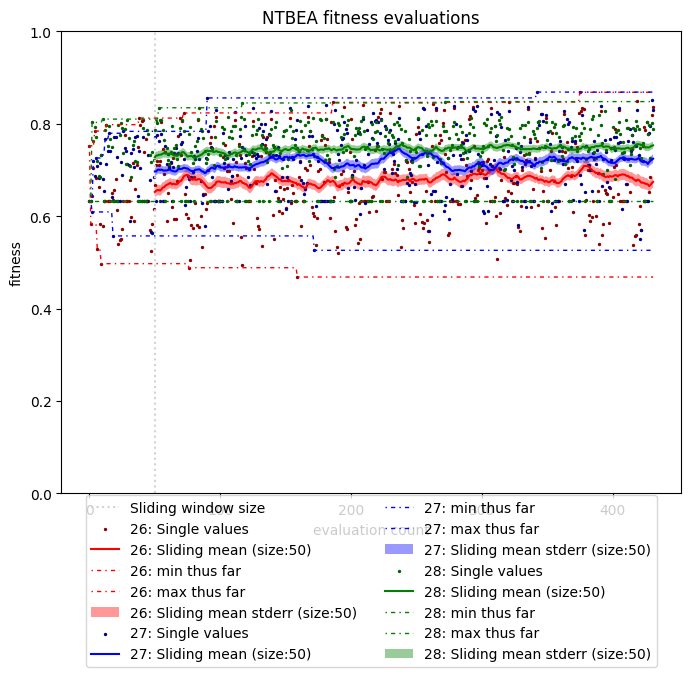

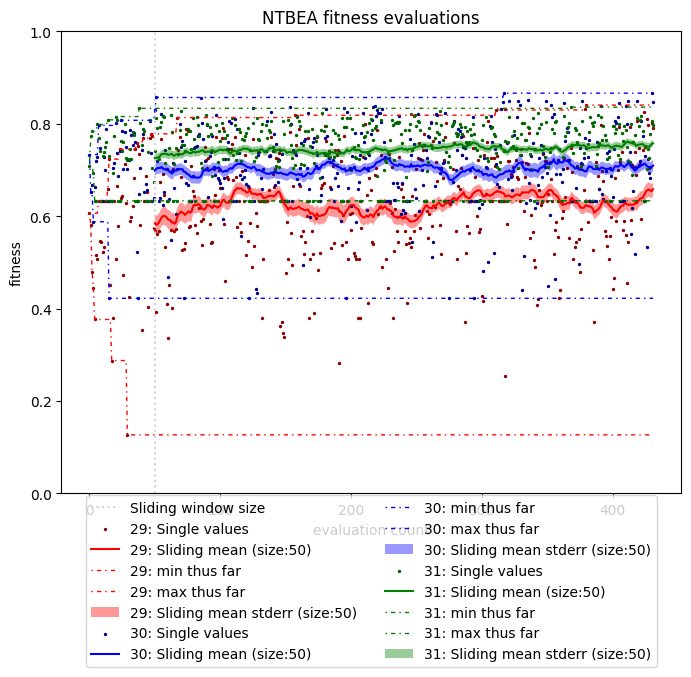

In [74]:
size = [8,6]

def plot_triplet(name, d1, d2, d3):
    fig = plt.figure(figsize=size)
    lgd = add_singles_to_plot(d1, fig.gca(), "darkred", "red", add_window_size = True)
    lgd = add_singles_to_plot(d2, fig.gca(), "darkblue", "blue")
    lgd = add_singles_to_plot(d3, fig.gca(), "darkgreen", "green")
    fig.savefig(out_folder+name, bbox_extra_artists=(lgd,), bbox_inches='tight')

plot_triplet("BEv.pdf", df.loc[0], df.loc[1], df.loc[2])
plot_triplet("BEv+C.pdf", df.loc[3], df.loc[4], df.loc[5])